In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots a per-event array (jet_pt) that has been masked to meet certain conditions (in this case, abs(jet eta) < 1).

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 60)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        # NanoEvents allows easy access to our jets with the Jet column.
        jets = events.Jet

        output['cutflow']['all events'] += jets.size
        output['cutflow']['number of jets'] += jets.counts.sum()
        
        # We want jets with an abs(eta) < 1. Conditionals act on every value in an array in Coffea, so this is easy.
        eta_max = (np.absolute(jets.eta) < 1)
        # eta_max is a Boolean array, with True in the place of values where the condition is met, and False otherwise. We want to sum up all the Trues (=1) in each sublist, then sum up all the sublists to get the number of jets with pt > 20.
        output['cutflow']['abs(eta) < 1'] += eta_max.sum().sum()
            
        # We define good_jets as the actual jets we want to graph. We mask it with the jets that have abs(eta) < 1.
        good_jets = jets[eta_max]
        # good_jets is no longer a Boolean array, so we can't just sum up the True's. We count the amount of jets and sum that.
        output['cutflow']['final good jets'] += good_jets.counts.sum()
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=good_jets.pt.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

from dask.distributed import Client
from coffea_casa import CoffeaCasaCluster

cluster = CoffeaCasaCluster()
cluster.adapt(minimum=4, maximum=16)
client = Client(cluster)

output = processor.run_uproot_job(fileset=fileset, 
                       treename="Events", 
                       processor_instance=Processor(),
                       executor=processor.dask_executor,
                       executor_args={'client': client, 'nano': True},
                       chunksize=250000)

{'protocol': 'tls://', 'security': Security(require_encryption=True, tls_ca_file='/etc/cmsaf-secrets/ca.pem', tls_client_cert='/etc/cmsaf-secrets/hostcert.pem', tls_client_key='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_cert='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_key='/etc/cmsaf-secrets/hostcert.pem', tls_worker_cert='/etc/cmsaf-secrets/hostcert.pem', tls_worker_key='/etc/cmsaf-secrets/hostcert.pem'), 'log_directory': 'logs', 'silence_logs': 'DEBUG', 'scheduler_options': {'port': 8786, 'dashboard_address': '8787', 'protocol': 'tls', 'external_address': 'tls://matousadamec-40gmail-2ecom.dask.coffea.casa:8786'}, 'job_extra': {'universe': 'docker', 'docker_image': 'coffeateam/coffea-casa-analysis:0.2.23', 'container_service_names': 'dask', 'dask_container_port': 8786, 'transfer_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/cmsaf-secrets/xcache_token', 'encrypt_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/c

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tls://192.168.145.131:8786
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-cba30e87-f2c3-11ea-8d0c-ae5d2030f5f0
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 11.6s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32849', name: htcondor--7504817.0--, memory: 0, processing: 1>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32849
distributed.core - INFO - Starting established connection


[                                        ] | 1% Completed |  8.7s9s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32850', name: htcondor--7504818.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32850
distributed.core - INFO - Starting established connection


[###                                     ] | 7% Completed | 26.5s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.183.52:32771', name: htcondor--7504821.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.183.52:32771
distributed.core - INFO - Starting established connection


[###                                     ] | 7% Completed | 27.7s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.206:32778', name: htcondor--7504820.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.206:32778
distributed.core - INFO - Starting established connection


[###                                     ] | 9% Completed | 32.1s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32851', name: htcondor--7504819.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32851
distributed.core - INFO - Starting established connection


[#####################################   ] | 93% Completed |  1min 27.9s

distributed.scheduler - INFO - Retire worker names ('htcondor--7504818.0--',)
distributed.scheduler - INFO - Retire workers {<Worker 'tls://129.93.182.3:32850', name: htcondor--7504818.0--, memory: 3, processing: 2>}
distributed.scheduler - INFO - Moving 2 keys to other workers


[#####################################   ] | 93% Completed |  1min 28.0s

distributed.scheduler - INFO - Remove worker <Worker 'tls://129.93.182.3:32850', name: htcondor--7504818.0--, memory: 3, processing: 2>
distributed.core - INFO - Removing comms to tls://129.93.182.3:32850


[######################################  ] | 95% Completed |  1min 28.9s

distributed.scheduler - INFO - Retire worker names ('htcondor--7504819.0--',)
distributed.scheduler - INFO - Retire workers {<Worker 'tls://129.93.182.3:32851', name: htcondor--7504819.0--, memory: 9, processing: 1>}
distributed.scheduler - INFO - Moving 8 keys to other workers


[######################################  ] | 95% Completed |  1min 29.0s

distributed.scheduler - INFO - Remove worker <Worker 'tls://129.93.182.3:32851', name: htcondor--7504819.0--, memory: 9, processing: 1>
distributed.core - INFO - Removing comms to tls://129.93.182.3:32851


[######################################  ] | 97% Completed |  1min 31.9s

distributed.scheduler - INFO - Retire worker names ('htcondor--7504820.0--',)
distributed.scheduler - INFO - Retire workers {<Worker 'tls://129.93.182.206:32778', name: htcondor--7504820.0--, memory: 20, processing: 0>}
distributed.scheduler - INFO - Moving 19 keys to other workers
distributed.scheduler - INFO - Remove worker <Worker 'tls://129.93.182.206:32778', name: htcondor--7504820.0--, memory: 20, processing: 0>
distributed.core - INFO - Removing comms to tls://129.93.182.206:32778


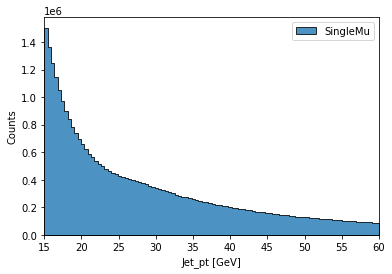

In [4]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of jets 170952895
abs(eta) < 1 39563735
final good jets 39563735
